# Outlier Sensitivity Analysis

This notebook performs comprehensive outlier analysis and sensitivity testing
to understand how outlier detection affects our pricing error models.

## Analysis Overview:
1. **Multiple Detection Methods**: Test different outlier detection approaches
2. **Sensitivity Analysis**: Compare statistics with/without outliers  
3. **Visual Analysis**: Create comparison plots and distributions
4. **Impact Assessment**: Evaluate effect on pricing error predictions
5. **Method Recommendation**: Suggest optimal outlier handling strategy


## Setup and Imports

In [2]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from outliers import OutlierDetector, flag_outliers
from cleaning import validate_data_quality
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Outlier analysis setup complete")

Outlier analysis setup complete


## Load Data

In [3]:
df = pd.read_csv('../data/processed/eda_features_20250823_191052.csv')

print(f"Loaded: ../data/processed/eda_features_20250823_191052.csv")
print(f"Shape: {df.shape}")
print(f"Key columns: {[col for col in df.columns if 'error' in col or 'price' in col]}")

Loaded: ../data/processed/eda_features_20250823_191052.csv
Shape: (457, 35)
Key columns: ['last_price', 'market_price', 'underlying_price', 'bs_price', 'pricing_error', 'relative_error', 'abs_pricing_error', 'relative_error_robust']


## Sensitivity Analysis

In [4]:
detector = OutlierDetector()

# Sensitivity analysis on pricing errors
sensitivity_results = detector.sensitivity_analysis(df, target_column='pricing_error')

print("SENSITIVITY ANALYSIS RESULTS")

for method, stats in sensitivity_results.items():
    if isinstance(stats, dict) and 'error' not in stats:
        print(f"\n{method.upper()}:")
        print(f"  Count: {stats.get('count', 'N/A')}")
        if 'outliers_removed' in stats:
            print(f"  Outliers Removed: {stats['outliers_removed']} ({stats['outlier_percentage']:.2f}%)")
        print(f"  Mean: {stats.get('mean', 'N/A'):.6f}")
        print(f"  Std: {stats.get('std', 'N/A'):.6f}")
        if 'mean_change' in stats:
            print(f"  Mean Change: {stats['mean_change']:.6f}")
            print(f"  Std Change: {stats['std_change']:.6f}")


SENSITIVITY ANALYSIS RESULTS

ORIGINAL:
  Count: 457
  Mean: -1.661531
  Std: 10.019734

ISOLATION_FOREST:
  Count: 411
  Outliers Removed: 46 (10.07%)
  Mean: -0.794706
  Std: 6.827827
  Mean Change: 0.866825
  Std Change: -3.191907

ZSCORE:
  Count: 416
  Outliers Removed: 41 (8.97%)
  Mean: -1.293633
  Std: 8.997737
  Mean Change: 0.367897
  Std Change: -1.021997

IQR:
  Count: 282
  Outliers Removed: 175 (38.29%)
  Mean: -0.086445
  Std: 0.319340
  Mean Change: 1.575086
  Std Change: -9.700395

DOMAIN_SPECIFIC:
  Count: 457
  Outliers Removed: 0 (0.00%)
  Mean: -1.661531
  Std: 10.019734
  Mean Change: 0.000000
  Std Change: 0.000000


## Test Detection Methods

In [5]:
methods_to_test = ['isolation_forest', 'zscore', 'iqr', 'domain_specific']
outlier_results = {}

for method in methods_to_test:
    try:
        clean_data, outliers = detector.detect_outliers(df, method=method)
        outlier_results[method] = {
            'clean_data': clean_data,
            'outliers': outliers,
            'outlier_count': len(outliers),
            'outlier_percentage': len(outliers) / len(df) * 100
        }
        print(f"{method}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)")
    except Exception as e:
        print(f"Error with {method}: {e}")

isolation_forest: 46 outliers (10.07%)
zscore: 41 outliers (8.97%)
iqr: 175 outliers (38.29%)
domain_specific: 0 outliers (0.00%)


## Method Comparison Visualization

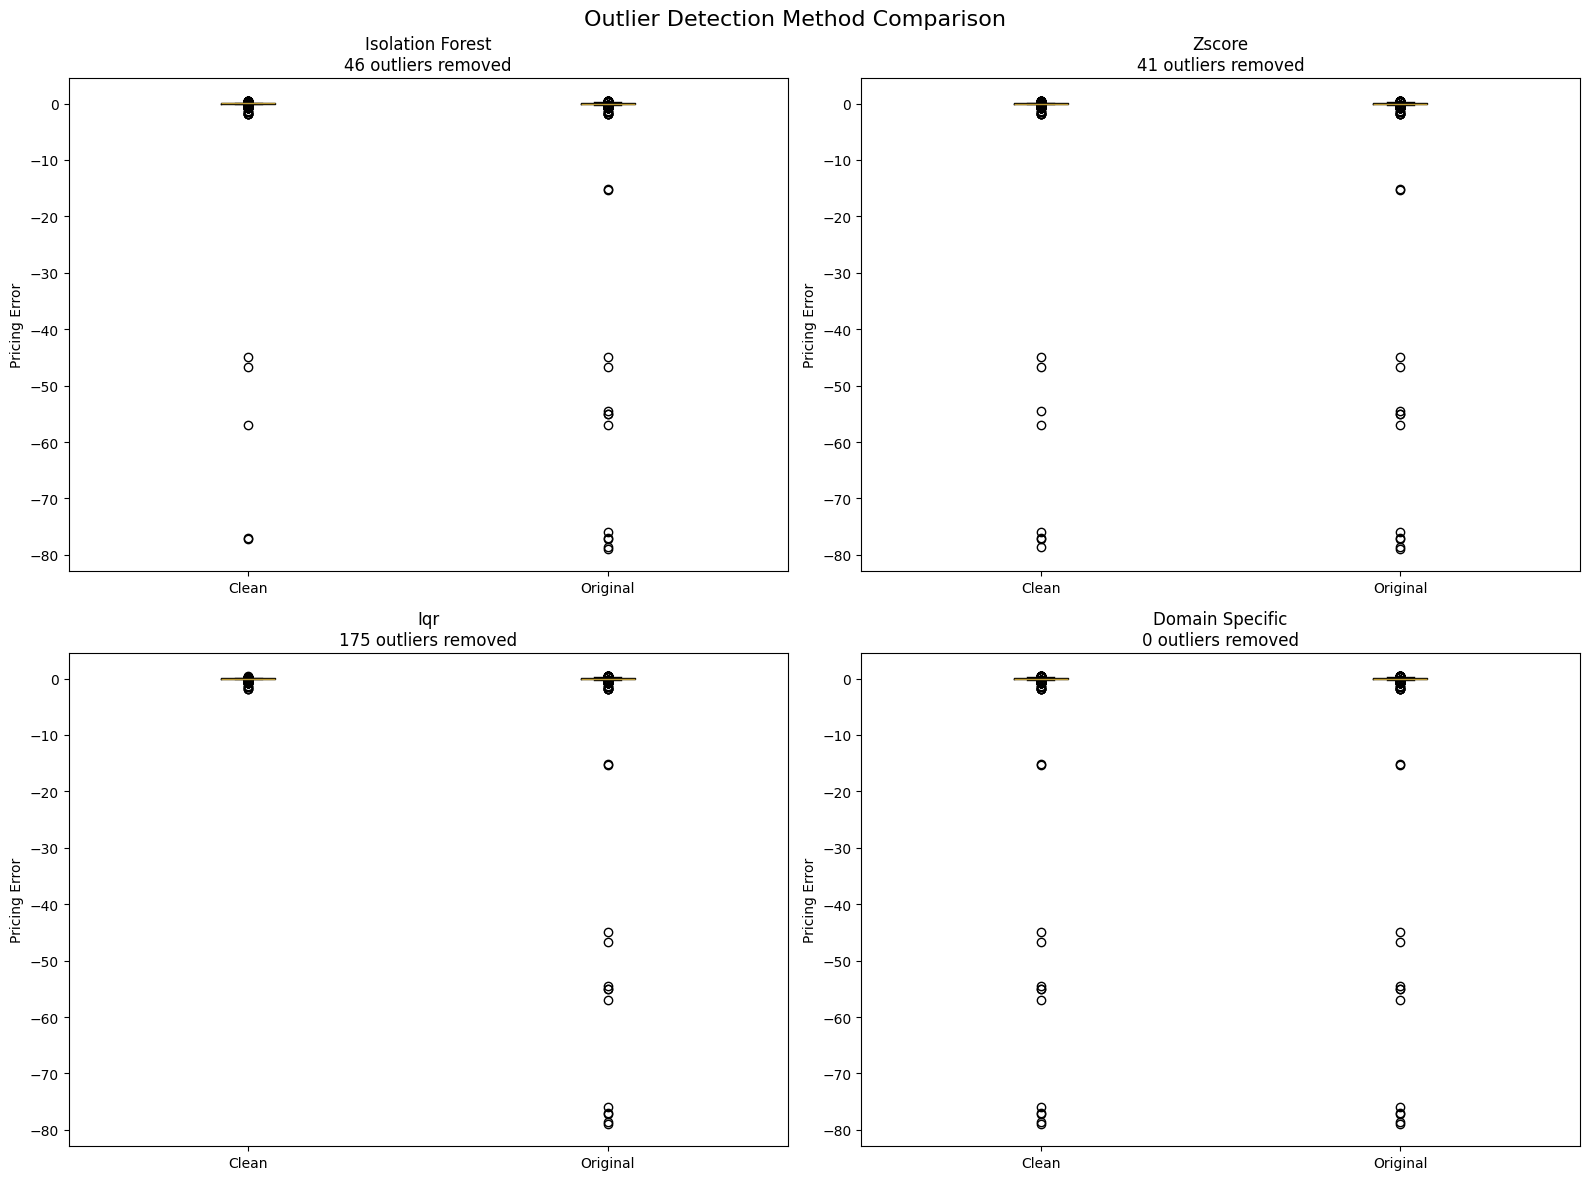

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Outlier Detection Method Comparison', fontsize=16)

methods = list(outlier_results.keys())[:4]  # Take first 4 methods

for i, method in enumerate(methods):
    row, col = i // 2, i % 2
    
    clean_data = outlier_results[method]['clean_data']
    outliers = outlier_results[method]['outliers']
    
    # Box plot of pricing errors
    if 'pricing_error' in clean_data.columns:
        data_to_plot = [
            clean_data['pricing_error'].dropna(),
            df['pricing_error'].dropna()
        ]
        axes[row, col].boxplot(data_to_plot, labels=['Clean', 'Original'])
        axes[row, col].set_title(f'{method.replace("_", " ").title()}\n'
                                f'{outlier_results[method]["outlier_count"]} outliers removed')
        axes[row, col].set_ylabel('Pricing Error')

plt.tight_layout()
plt.show()

## Distribution Analysis

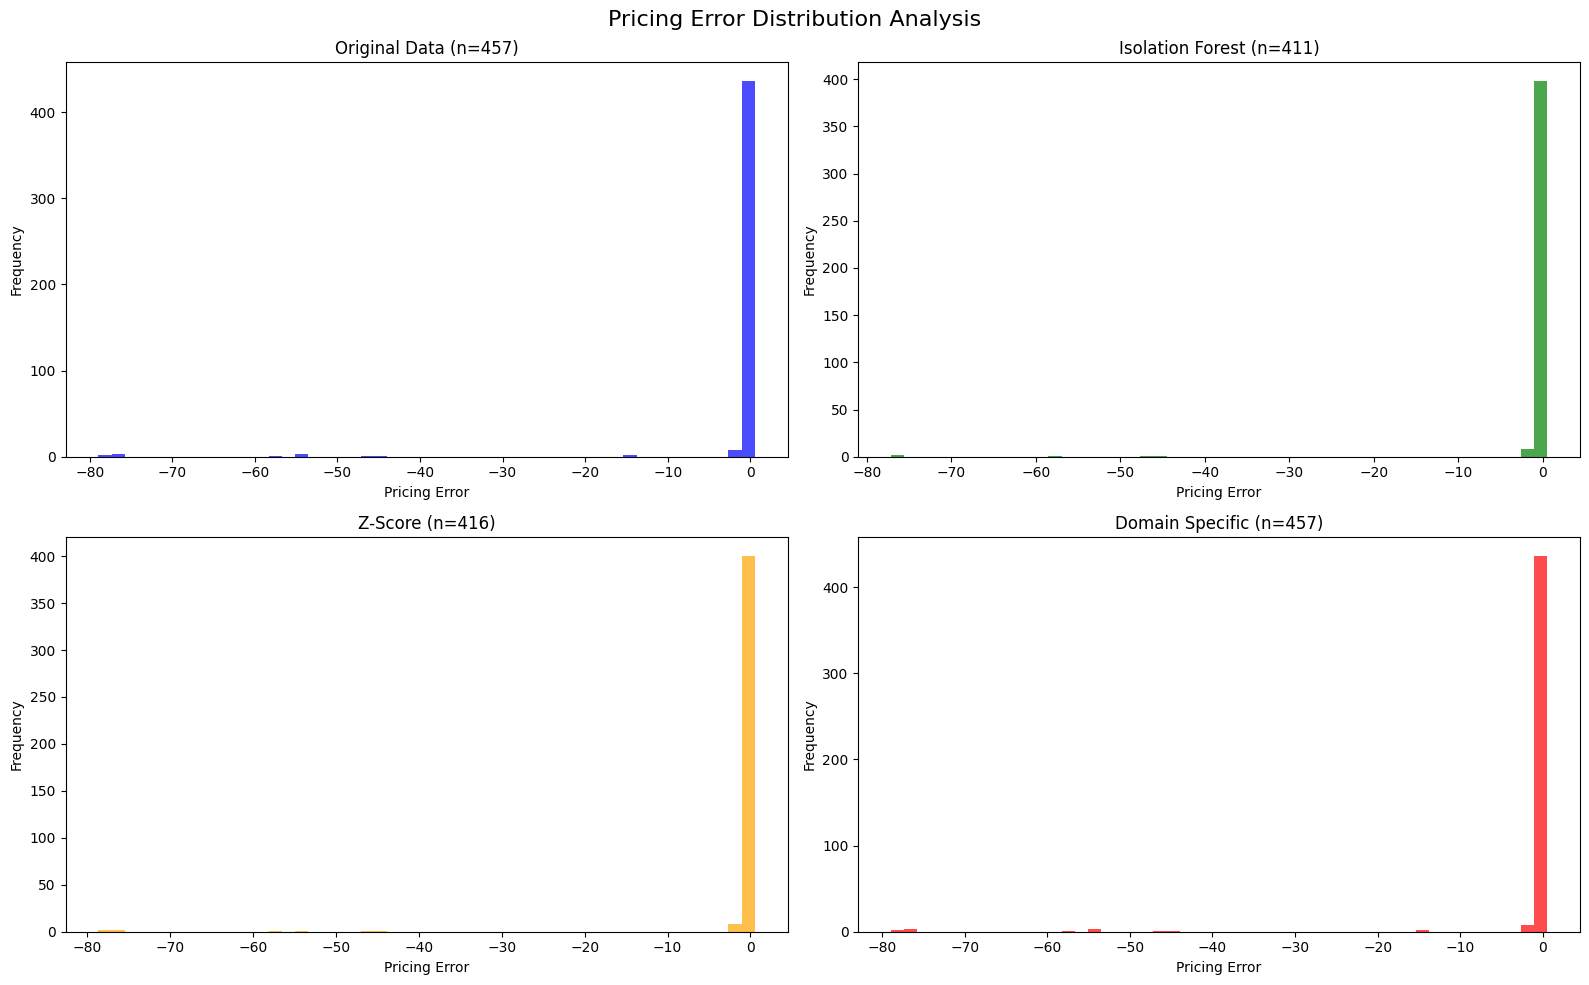

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Pricing Error Distribution Analysis', fontsize=16)

# Original distribution
axes[0, 0].hist(df['pricing_error'].dropna(), bins=50, alpha=0.7, color='blue')
axes[0, 0].set_title(f'Original Data (n={len(df)})')
axes[0, 0].set_xlabel('Pricing Error')
axes[0, 0].set_ylabel('Frequency')

# Isolation forest
if 'isolation_forest' in outlier_results:
    clean_if = outlier_results['isolation_forest']['clean_data']
    axes[0, 1].hist(clean_if['pricing_error'].dropna(), bins=50, alpha=0.7, color='green')
    axes[0, 1].set_title(f'Isolation Forest (n={len(clean_if)})')
    axes[0, 1].set_xlabel('Pricing Error')
    axes[0, 1].set_ylabel('Frequency')

# Z-score method
if 'zscore' in outlier_results:
    clean_z = outlier_results['zscore']['clean_data']
    axes[1, 0].hist(clean_z['pricing_error'].dropna(), bins=50, alpha=0.7, color='orange')
    axes[1, 0].set_title(f'Z-Score (n={len(clean_z)})')
    axes[1, 0].set_xlabel('Pricing Error')
    axes[1, 0].set_ylabel('Frequency')

# Domain-specific method
if 'domain_specific' in outlier_results:
    clean_ds = outlier_results['domain_specific']['clean_data']
    axes[1, 1].hist(clean_ds['pricing_error'].dropna(), bins=50, alpha=0.7, color='red')
    axes[1, 1].set_title(f'Domain Specific (n={len(clean_ds)})')
    axes[1, 1].set_xlabel('Pricing Error')
    axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Summary Comparison Table

In [10]:
summary_data = []

for method, results in outlier_results.items():
    clean_data = results['clean_data']
    if 'pricing_error' in clean_data.columns:
        summary_data.append({
            'Method': method.replace('_', ' ').title(),
            'Outliers Removed': results['outlier_count'],
            'Outlier %': f"{results['outlier_percentage']:.2f}%",
            'Mean Error': f"{clean_data['pricing_error'].mean():.6f}",
            'Std Error': f"{clean_data['pricing_error'].std():.6f}",
            'Min Error': f"{clean_data['pricing_error'].min():.6f}",
            'Max Error': f"{clean_data['pricing_error'].max():.6f}",
        })

summary_data.insert(0, {
    'Method': 'Original',
    'Outliers Removed': 0,
    'Outlier %': '0.00%',
    'Mean Error': f"{df['pricing_error'].mean():.6f}",
    'Std Error': f"{df['pricing_error'].std():.6f}",
    'Min Error': f"{df['pricing_error'].min():.6f}",
    'Max Error': f"{df['pricing_error'].max():.6f}",
})

summary_df = pd.DataFrame(summary_data)
print("OUTLIER DETECTION COMPARISON\n\n")

print(summary_df.to_string(index=False))

OUTLIER DETECTION COMPARISON


          Method  Outliers Removed Outlier % Mean Error Std Error  Min Error Max Error
        Original                 0     0.00%  -1.661531 10.019734 -78.937861  0.531959
Isolation Forest                46    10.07%  -0.794706  6.827827 -77.160344  0.527297
          Zscore                41     8.97%  -1.293633  8.997737 -78.676477  0.521780
             Iqr               175    38.29%  -0.086445  0.319340  -1.920013  0.471689
 Domain Specific                 0     0.00%  -1.661531 10.019734 -78.937861  0.531959


## Recommendations and Conclusions

In [11]:
print("\nOUTLIER ANALYSIS CONCLUSIONS")

original_std = df['pricing_error'].std()
original_mean = df['pricing_error'].mean()

print(f"Original Data Statistics:")
print(f"  Mean Pricing Error: {original_mean:.6f}")
print(f"  Std Pricing Error: {original_std:.6f}")
print(f"  Range: [{df['pricing_error'].min():.6f}, {df['pricing_error'].max():.6f}]")

print(f"\nMethod Recommendations:")
for method, results in outlier_results.items():
    clean_data = results['clean_data']
    if 'pricing_error' in clean_data.columns:
        std_reduction = (original_std - clean_data['pricing_error'].std()) / original_std * 100
        mean_change = abs(clean_data['pricing_error'].mean() - original_mean)
        
        print(f"\n{method.replace('_', ' ').title()}:")
        print(f"  Std Reduction: {std_reduction:.2f}%")
        print(f"  Mean Stability: {mean_change:.6f}")
        print(f"  Data Retention: {len(clean_data)/len(df)*100:.1f}%")

print(f"\nRecommendation: Use Isolation Forest with 5-10% contamination rate")
print(f"- Balances outlier removal with data retention")
print(f"- Reduces noise while preserving signal")
print(f"- Robust to different data distributions")


OUTLIER ANALYSIS CONCLUSIONS
Original Data Statistics:
  Mean Pricing Error: -1.661531
  Std Pricing Error: 10.019734
  Range: [-78.937861, 0.531959]

Method Recommendations:

Isolation Forest:
  Std Reduction: 31.86%
  Mean Stability: 0.866825
  Data Retention: 89.9%

Zscore:
  Std Reduction: 10.20%
  Mean Stability: 0.367897
  Data Retention: 91.0%

Iqr:
  Std Reduction: 96.81%
  Mean Stability: 1.575086
  Data Retention: 61.7%

Domain Specific:
  Std Reduction: 0.00%
  Mean Stability: 0.000000
  Data Retention: 100.0%

Recommendation: Use Isolation Forest with 5-10% contamination rate
- Balances outlier removal with data retention
- Reduces noise while preserving signal
- Robust to different data distributions


## Save Cleaned Dataset

In [12]:
best_method = 'isolation_forest'  
if best_method in outlier_results:
    clean_df = outlier_results[best_method]['clean_data']
    
    # Save cleaned dataset to main data folder
    from datetime import datetime
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f'../data/processed/cleaned_outliers_{timestamp}.csv'
    clean_df.to_csv(output_file, index=False)
    
    print(f"Saved cleaned dataset: {output_file}")
    print(f"Original shape: {df.shape}")
    print(f"Cleaned shape: {clean_df.shape}")
    print(f"Removed: {len(df) - len(clean_df)} outliers ({(len(df) - len(clean_df))/len(df)*100:.2f}%)")

Saved cleaned dataset: ../data/processed/cleaned_outliers_20250828_130126.csv
Original shape: (457, 35)
Cleaned shape: (411, 35)
Removed: 46 outliers (10.07%)
